# Interest-rate curves #
## 6. EONIA curve bootstrapping ##

In [1]:
import math
import datetime
import matplotlib.pyplot as plot

In [2]:
import QuantLib as ql

In [3]:
today = ql.Date(11, ql.December, 2012)
ql.Settings.instance().evaluationDate = today

### First try ###

In [4]:
helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                ql.Period(1, ql.Days), fixingDays,
                                ql.TARGET(), ql.Following, False, ql.Actual360())
           for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)]]

In [5]:
eonia = ql.Eonia()

In [6]:
helpers += [ql.OISRateHelper(2, ql.Period(*tenor),
                             ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia)
            for rate, tenor in [(0.070, (1, ql.Weeks)), (0.069, (2, ql.Weeks)),
                                (0.078, (3, ql.Weeks)), (0.074, (1, ql.Months))]]

In [7]:
helpers += [ql.DatedOISRateHelper(start_date, end_date,
                                  ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia)
            for rate, start_date, end_date in [
                (0.046, ql.Date(16, ql.January, 2013), ql.Date(13, ql.February, 2013)),
                (0.016, ql.Date(13, ql.February, 2013), ql.Date(13, ql.March, 2013)),
                (-0.007, ql.Date(13, ql.March, 2013), ql.Date(10, ql.April, 2013)),
                (-0.013, ql.Date(10, ql.April, 2013), ql.Date(8, ql.May, 2013)),
                (-0.014, ql.Date(8, ql.May, 2013), ql.Date(12, ql.June, 2013))]]

In [8]:
helpers += [ql.OISRateHelper(2, ql.Period(*tenor),
            ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia)
            for rate, tenor in [(0.002, (15, ql.Months)), (0.008, (18, ql.Months)),
                                (0.021, (21, ql.Months)), (0.036, (2, ql.Years)),
                                (0.127, (3, ql.Years)), (0.274, (4, ql.Years)),
                                (0.456, (5, ql.Years)), (0.647, (6, ql.Years)),
                                (0.827, (7, ql.Years)), (0.996, (8, ql.Years)),
                                (1.147, (9, ql.Years)), (1.280, (10, ql.Years)),
                                (1.404, (11, ql.Years)), (1.516, (12, ql.Years)),
                                (1.764, (15, ql.Years)), (1.939, (20, ql.Years)),
                                (2.003, (25, ql.Years)), (2.038, (30, ql.Years))]]

In [9]:
eonia_curve_c = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), helpers, ql.Actual365Fixed())
eonia_curve_c.enableExtrapolation()

In [10]:
today = eonia_curve_c.referenceDate()
end = today + ql.Period(2, ql.Years)
dates = [ql.Date(serial) for serial in range(today.serialNumber(), end.serialNumber() + 1)]
rates_c = [eonia_curve_c.forwardRate(d, ql.TARGET().advance(d, 1, ql.Days), 
                                     ql.Actual360(), ql.Simple).rate() for d in dates ]

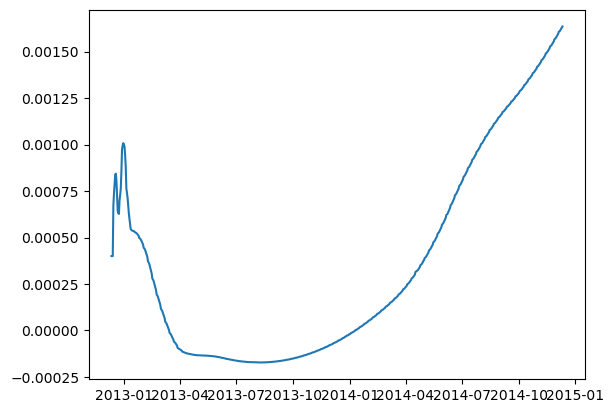

In [11]:
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_c, '-');

### Turn-of-year jumps ###

In [12]:
eonia_curve_ff = ql.PiecewiseFlatForward(0, ql.TARGET(), helpers, ql.Actual365Fixed())
eonia_curve_ff.enableExtrapolation()

In [13]:
end = today + ql.Period(6, ql.Months)
dates = [ql.Date(serial) for serial in range(today.serialNumber(), end.serialNumber() + 1)]
rates_ff = [eonia_curve_ff.forwardRate(d, ql.TARGET().advance(d, 1, ql.Days),
                                       ql.Actual360(), ql.Simple).rate() for d in dates]

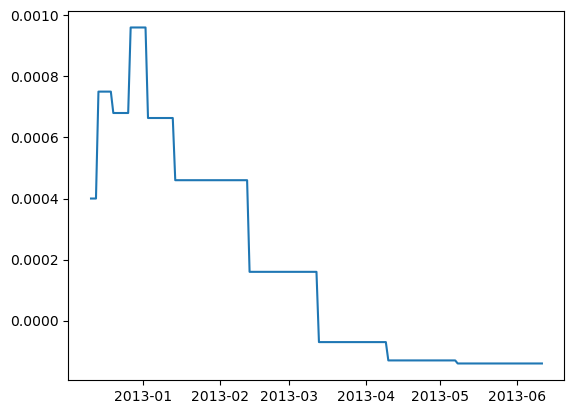

In [14]:
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_ff, '-');

In [15]:
nodes = list(eonia_curve_ff.nodes())

In [16]:
nodes[:9]

[(Date(11,12,2012), 0.00040555533025081675),
 (Date(12,12,2012), 0.00040555533025081675),
 (Date(13,12,2012), 0.00040555533047721286),
 (Date(14,12,2012), 0.00040555533047721286),
 (Date(20,12,2012), 0.0007604110692568178),
 (Date(27,12,2012), 0.0006894305026004767),
 (Date(3,1,2013), 0.0009732981324671213),
 (Date(14,1,2013), 0.0006728161005748453),
 (Date(13,2,2013), 0.000466380545910482)]

In [17]:
nodes[6] = (nodes[6][0], (nodes[5][1]+nodes[7][1]) / 2)
nodes[:9]

[(Date(11,12,2012), 0.00040555533025081675),
 (Date(12,12,2012), 0.00040555533025081675),
 (Date(13,12,2012), 0.00040555533047721286),
 (Date(14,12,2012), 0.00040555533047721286),
 (Date(20,12,2012), 0.0007604110692568178),
 (Date(27,12,2012), 0.0006894305026004767),
 (Date(3,1,2013), 0.000681123301587661),
 (Date(14,1,2013), 0.0006728161005748453),
 (Date(13,2,2013), 0.000466380545910482)]

In [18]:
temp_dates, temp_rates = zip(*nodes)
temp_curve = ql.ForwardCurve(temp_dates, temp_rates, eonia_curve_ff.dayCounter())

In [19]:
temp_rates = [temp_curve.forwardRate(d, ql.TARGET().advance(d, 1, ql.Days), 
                                     ql.Actual360(), ql.Simple).rate() for d in dates]

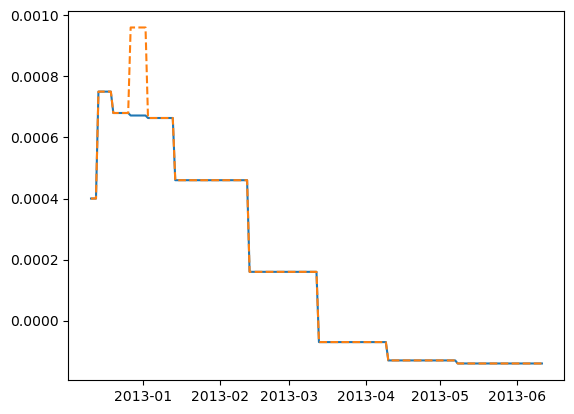

In [20]:
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], temp_rates, '-');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_ff, '--');

In [21]:
d1 = ql.Date(31, ql.December, 2012) - ql.Period(1, ql.Weeks)
d2 = ql.Date(31, ql.December, 2012) + ql.Period(1, ql.Weeks)

In [22]:
F = eonia_curve_ff.forwardRate(d1, d2, ql.Actual360(), ql.Simple).rate()
F_1 = temp_curve.forwardRate(d1, d2, ql.Actual360(), ql.Simple).rate()
print(f'{F * 100:.3f}%', f'{F_1 * 100:.3f}%')

0.082% 0.067%


In [23]:
t12 = eonia_curve_ff.dayCounter().yearFraction(d1, d2)
t_j = eonia_curve_ff.dayCounter().yearFraction(ql.Date(31, ql.December, 2012), ql.Date(2, ql.January, 2013))
J = (F - F_1)* t12 / t_j
print(f'{J * 100:.3f}%')

0.101%


In [24]:
B = 1.0 / (1.0 + J * t_j)
jumps = [ql.QuoteHandle(ql.SimpleQuote(B))]
jump_dates = [ql.Date(31, ql.December, 2012)]
eonia_curve_j = ql.PiecewiseFlatForward(0, ql.TARGET(), helpers, ql.Actual365Fixed(), jumps, jump_dates)

In [25]:
rates_j = [eonia_curve_j.forwardRate(d, ql.TARGET().advance(d, 1, ql.Days), 
                                     ql.Actual360(), ql.Simple).rate() for d in dates]

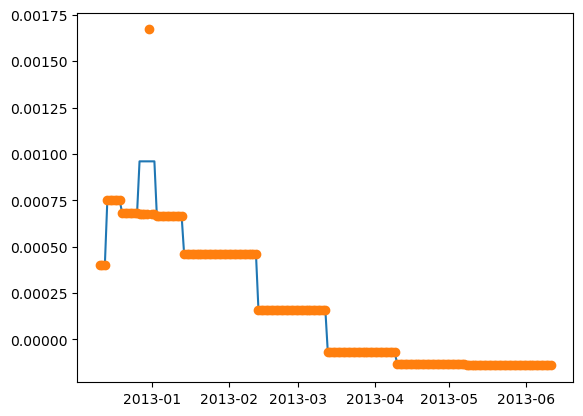

In [26]:
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_ff, '-');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_j, 'o');

In [27]:
eonia_curve = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), helpers, ql.Actual365Fixed(), jumps, jump_dates)
eonia_curve.enableExtrapolation()

In [28]:
rates_c = [eonia_curve_c.forwardRate(d, ql.TARGET().advance(d, 1, ql.Days), 
                                     ql.Actual360(), ql.Simple).rate() for d in dates]
rates = [eonia_curve.forwardRate(d, ql.TARGET().advance(d, 1, ql.Days), 
                                 ql.Actual360(), ql.Simple).rate() for d in dates]

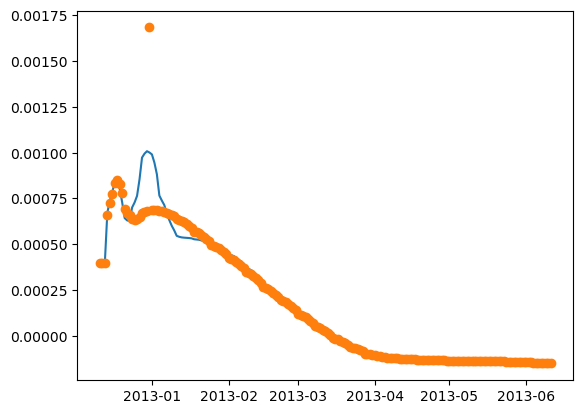

In [29]:
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_c, '-');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, 'o');

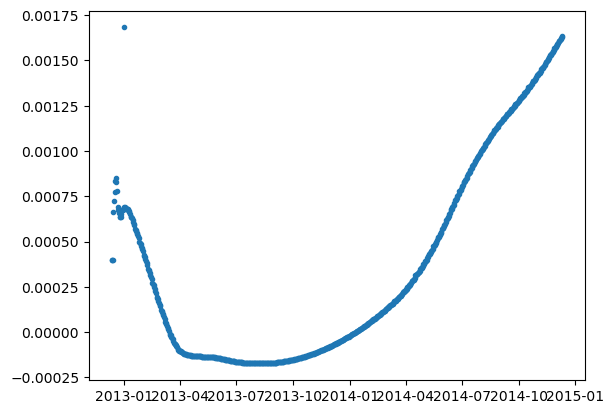

In [30]:
dates = [today + ql.Period(i, ql.Days) for i in range(0, 365 * 2 + 1)]
rates = [eonia_curve.forwardRate(d, ql.TARGET().advance(d, 1, ql.Days),
                                 ql.Actual360(), ql.Simple).rate() for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '.');

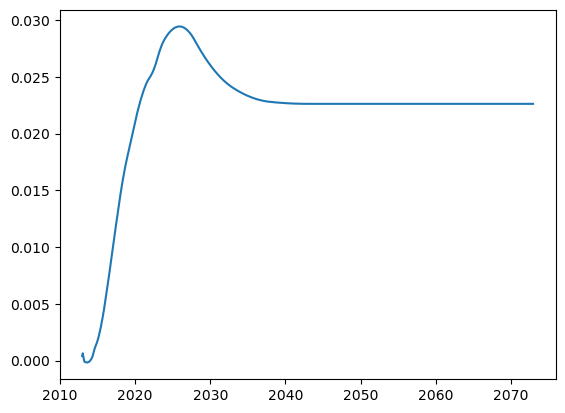

In [31]:
dates = [today + ql.Period(i, ql.Months) for i in range(0, 12 * 60 + 1)]
rates = [eonia_curve.forwardRate(d, ql.TARGET().advance(d, 1, ql.Days),
                                 ql.Actual360(), ql.Simple).rate() for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');